In [15]:
n <- 10000 #Tamaño de la población
size_a <- 1000 #Tamaño de la muestra no probabilística

xi <- rnorm(n, mean = 2, sd = 1) # Generamos xi a partir de una distribución normal N(2, 1)
ei <- rnorm(n, mean = 0, sd = sqrt(0.51)) # Generamos ei a partir de una distribución normal N(0, 0.51)
yi <- 3 + 0.7 * (xi - 2) + ei # Calculamos yi usando la ecuación yi = 3 + 0.7(xi - 2) + ei
ui <- rnorm(n, mean = 0, sd = 0.5) # Generamos ui a partir de una distribución normal N(0, 0.5^2)
yi_ast <- 2 + 0.9 * (yi - 3) + ui # Calculamos yi_ast usando la ecuación yi_ast = 2 + 0.9(yi - 3) + ui
datos_simul <- data.frame(xi = xi, yi = yi, yi_ast = yi_ast)

#Creamos la muestra probabilística
datos_simul$muestra_A <- 0
indices_seleccionados <- sample(1:n, size = size_a)
datos_simul$muestra_A[indices_seleccionados] <- 1

#Creamos la muestra no probabilística
size_muestra_B <- 5000
grupo_1 <- which(datos_simul$xi <= 2)  # Indices del grupo con xi <= 2
grupo_2 <- which(datos_simul$xi > 2)   # Indices del grupo con xi > 2
n_grupo_1 <- floor((3/5) * size_muestra_B)  # 3/5 del tamaño de la muestra para grupo_1
n_grupo_2 <- size_muestra_B - n_grupo_1     # El resto (2/5) para grupo_2
muestras_grupo_1 <- sample(grupo_1, size = n_grupo_1)
muestras_grupo_2 <- sample(grupo_2, size = n_grupo_2)
datos_simul$muestra_B <- 0
datos_simul$muestra_B[muestras_grupo_1] <- 1
datos_simul$muestra_B[muestras_grupo_2] <- 1

,xi,yi,yi_ast,muestra_A,muestra_B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.8055325,2.844448,2.1293793,0,1
2,2.3943933,2.342176,1.3436692,0,1
3,0.9631785,1.860783,1.9176751,0,1
4,1.6078820,2.642730,0.9132405,0,1
5,3.0243878,3.023734,2.0500059,0,0
6,0.8369444,2.696996,1.3008383,0,0


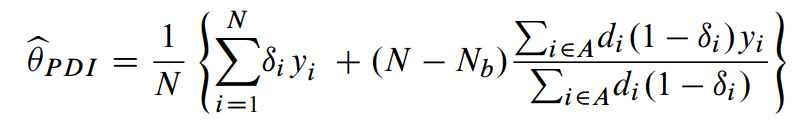

In [25]:
N <- n
Nb <- size_muestra_B

sum_B <- sum(datos_simul$yi[datos_simul$muestra_B == 1])

# Calculamos el estimador de PDI
theta_PDI <- (1 / N) * (
  sum_B +
  (N - Nb) * mean(datos_simul$yi[datos_simul$muestra_A == 1 & datos_simul$muestra_B == 0])
)

# Mostrar el resultado del estimador
theta_PDI


[1] 3.044402

#### Simulación de MonteCarlo del paper (Sin incluir el estimador de calibración)

In [33]:
# ---- Configuración inicial ----
n <- 10000 # Tamaño de la población
size_a <- 1000 # Tamaño de la muestra probabilística
size_muestra_B <- 5000 # Tamaño de la muestra no probabilística

In [34]:
# ---- Función para generar los datos ----
generar_datos <- function(n) {
  xi <- rnorm(n, mean = 2, sd = 1) # Generamos xi a partir de una distribución normal N(2, 1)
  ei <- rnorm(n, mean = 0, sd = sqrt(0.51)) # Generamos ei a partir de una distribución normal N(0, 0.51)
  yi <- 3 + 0.7 * (xi - 2) + ei # Calculamos yi
  ui <- rnorm(n, mean = 0, sd = 0.5) # Generamos ui a partir de una normal N(0, 0.5^2)
  yi_ast <- 2 + 0.9 * (yi - 3) + ui # Calculamos yi_ast (con error de medición)
  datos <- data.frame(xi = xi, yi = yi, yi_ast = yi_ast)
  return(datos)
}

# ---- Función para seleccionar muestras A y B ----
seleccionar_muestras <- function(datos, size_a, size_muestra_B) {
  n <- nrow(datos)
  
  # Muestra A (probabilística)
  datos$muestra_A <- 0
  indices_seleccionados <- sample(1:n, size = size_a)
  datos$muestra_A[indices_seleccionados] <- 1
  
  # Muestra B (no probabilística)
  grupo_1 <- which(datos$xi <= 2)  # Indices del grupo con xi <= 2
  grupo_2 <- which(datos$xi > 2)   # Indices del grupo con xi > 2
  n_grupo_1 <- floor((3/5) * size_muestra_B)  # 3/5 para grupo_1
  n_grupo_2 <- size_muestra_B - n_grupo_1     # 2/5 para grupo_2
  muestras_grupo_1 <- sample(grupo_1, size = n_grupo_1)
  muestras_grupo_2 <- sample(grupo_2, size = n_grupo_2)
  datos$muestra_B <- 0
  datos$muestra_B[muestras_grupo_1] <- 1
  datos$muestra_B[muestras_grupo_2] <- 1
  
  return(datos)
}

# ---- Función para calcular theta_PDI en cada escenario ----
calcular_theta_pdi <- function(datos, escenario) {
  N <- nrow(datos)
  Nb <- sum(datos$muestra_B == 1)
  
  if (escenario == 1) {
    # Escenario 1: Usando yi (sin error)
    sum_B <- sum(datos$yi[datos$muestra_B == 1])
    theta_PDI <- (1 / N) * (sum_B + (N - Nb) * mean(datos$yi[datos$muestra_A == 1 & datos$muestra_B == 0]))
  } else if (escenario == 2) {
    # Escenario 2: Error en la muestra B (yi_ast para muestra B, yi para muestra A)
    sum_B <- sum(datos$yi_ast[datos$muestra_B == 1])
    theta_PDI <- (1 / N) * (sum_B + (N - Nb) * mean(datos$yi[datos$muestra_A == 1 & datos$muestra_B == 0]))
  } else if (escenario == 3) {
    # Escenario 3: Error en la muestra A (yi_ast para muestra A, yi para muestra B)
    sum_B <- sum(datos$yi[datos$muestra_B == 1])
    theta_PDI <- (1 / N) * (sum_B + (N - Nb) * mean(datos$yi_ast[datos$muestra_A == 1 & datos$muestra_B == 0]))
  }
  
  return(theta_PDI)
}


In [35]:
# ---- Simulación de Monte Carlo ----
simulacion_montecarlo <- function(n_reps, size_a, size_muestra_B) {
  resultados <- data.frame(
    mean_A_esc1 = numeric(n_reps),
    mean_B_esc1 = numeric(n_reps),
    mean_A_esc2 = numeric(n_reps),
    mean_B_esc2 = numeric(n_reps),
    mean_A_esc3 = numeric(n_reps),
    mean_B_esc3 = numeric(n_reps),
    theta_PDI_esc1 = numeric(n_reps),
    theta_PDI_esc2 = numeric(n_reps),
    theta_PDI_esc3 = numeric(n_reps),
    diff_A_esc1 = numeric(n_reps),
    diff_B_esc1 = numeric(n_reps),
    diff_A_esc2 = numeric(n_reps),
    diff_B_esc2 = numeric(n_reps),
    diff_A_esc3 = numeric(n_reps),
    diff_B_esc3 = numeric(n_reps),
    diff_PDI_esc1 = numeric(n_reps),
    diff_PDI_esc2 = numeric(n_reps),
    diff_PDI_esc3 = numeric(n_reps)
  )
  
  for (rep in 1:n_reps) {
    # Generamos los datos y seleccionamos muestras
    datos_simul <- generar_datos(n)
    datos_simul <- seleccionar_muestras(datos_simul, size_a, size_muestra_B)
    
    # Cálculo de las medias en muestra A y B en los tres escenarios
    mean_A_esc1 <- mean(datos_simul$yi[datos_simul$muestra_A == 1])
    mean_B_esc1 <- mean(datos_simul$yi[datos_simul$muestra_B == 1])
    
    mean_A_esc2 <- mean(datos_simul$yi[datos_simul$muestra_A == 1])
    mean_B_esc2 <- mean(datos_simul$yi_ast[datos_simul$muestra_B == 1])
    
    mean_A_esc3 <- mean(datos_simul$yi_ast[datos_simul$muestra_A == 1])
    mean_B_esc3 <- mean(datos_simul$yi[datos_simul$muestra_B == 1])
    
    # Cálculo de theta_PDI en los tres escenarios
    theta_PDI_esc1 <- calcular_theta_pdi(datos_simul, escenario = 1)
    theta_PDI_esc2 <- calcular_theta_pdi(datos_simul, escenario = 2)
    theta_PDI_esc3 <- calcular_theta_pdi(datos_simul, escenario = 3)
    
    # Guardamos los resultados
    resultados$mean_A_esc1[rep] <- mean_A_esc1
    resultados$mean_B_esc1[rep] <- mean_B_esc1
    resultados$mean_A_esc2[rep] <- mean_A_esc2
    resultados$mean_B_esc2[rep] <- mean_B_esc2
    resultados$mean_A_esc3[rep] <- mean_A_esc3
    resultados$mean_B_esc3[rep] <- mean_B_esc3
    resultados$theta_PDI_esc1[rep] <- theta_PDI_esc1
    resultados$theta_PDI_esc2[rep] <- theta_PDI_esc2
    resultados$theta_PDI_esc3[rep] <- theta_PDI_esc3
    
    # Diferencias con respecto a la media verdadera de la población
    media_poblacion <- mean(datos_simul$yi)
    resultados$diff_A_esc1[rep] <- mean_A_esc1 - media_poblacion
    resultados$diff_B_esc1[rep] <- mean_B_esc1 - media_poblacion
    resultados$diff_A_esc2[rep] <- mean_A_esc2 - media_poblacion
    resultados$diff_B_esc2[rep] <- mean_B_esc2 - media_poblacion
    resultados$diff_A_esc3[rep] <- mean_A_esc3 - media_poblacion
    resultados$diff_B_esc3[rep] <- mean_B_esc3 - media_poblacion
    resultados$diff_PDI_esc1[rep] <- theta_PDI_esc1 - media_poblacion
    resultados$diff_PDI_esc2[rep] <- theta_PDI_esc2 - media_poblacion
    resultados$diff_PDI_esc3[rep] <- theta_PDI_esc3 - media_poblacion
  }
  
  return(resultados)
}

# ---- Ejecución de la simulación de Monte Carlo ----
n_reps <- 1000
resultados_simulacion <- simulacion_montecarlo(n_reps, size_a, size_muestra_B)

In [37]:
# ---- Presentación de resultados en tablas ----
library(dplyr)

# Promedios de las diferencias con respecto a la población
promedios <- resultados_simulacion %>%
  summarise(
    Mean_A_Esc1 = mean(diff_A_esc1),
    Mean_B_Esc1 = mean(diff_B_esc1),
    Theta_PDI_Esc1 = mean(diff_PDI_esc1),
    Mean_A_Esc2 = mean(diff_A_esc2),
    Mean_B_Esc2 = mean(diff_B_esc2),
    Theta_PDI_Esc2 = mean(diff_PDI_esc2),
    Mean_A_Esc3 = mean(diff_A_esc3),
    Mean_B_Esc3 = mean(diff_B_esc3),
    Theta_PDI_Esc3 = mean(diff_PDI_esc3)
  )

# Desviación estándar de las diferencias
desviaciones <- resultados_simulacion %>%
  summarise(
    SD_A_Esc1 = sd(diff_A_esc1),
    SD_B_Esc1 = sd(diff_B_esc1),
    SD_Theta_PDI_Esc1 = sd(diff_PDI_esc1),
    SD_A_Esc2 = sd(diff_A_esc2),
    SD_B_Esc2 = sd(diff_B_esc2),
    SD_Theta_PDI_Esc2 = sd(diff_PDI_esc2),
    SD_A_Esc3 = sd(diff_A_esc3),
    SD_B_Esc3 = sd(diff_B_esc3),
    SD_Theta_PDI_Esc3 = sd(diff_PDI_esc3)
  )

# ---- Organización de los resultados en un solo data.frame ----

# Crear un data frame con los resultados
resultados_finales <- data.frame(
  Escenario = rep(c("Esc 1", "Esc 2", "Esc 3"), each = 3),
  Estimador = rep(c("A", "B", "PDI"), 3),
  Sesgo = c(
    promedios$Mean_A_Esc1, promedios$Mean_B_Esc1, promedios$Theta_PDI_Esc1,
    promedios$Mean_A_Esc2, promedios$Mean_B_Esc2, promedios$Theta_PDI_Esc2,
    promedios$Mean_A_Esc3, promedios$Mean_B_Esc3, promedios$Theta_PDI_Esc3
  ),
  Desviacion = c(
    desviaciones$SD_A_Esc1, desviaciones$SD_B_Esc1, desviaciones$SD_Theta_PDI_Esc1,
    desviaciones$SD_A_Esc2, desviaciones$SD_B_Esc2, desviaciones$SD_Theta_PDI_Esc2,
    desviaciones$SD_A_Esc3, desviaciones$SD_B_Esc3, desviaciones$SD_Theta_PDI_Esc3
  )
)

# Mostrar el data.frame final
resultados_finales

Escenario,Estimador,Sesgo,Desviacion
<chr>,<chr>,<dbl>,<dbl>
Esc 1,A,-0.0007039462,0.02935429
Esc 1,B,-0.1117933110,0.01016108
Esc 1,PDI,-0.0003732152,0.02037333
Esc 2,A,-0.0007039462,0.02935429
Esc 2,B,-1.1003559850,0.01164277
Esc 2,PDI,-0.4946545522,0.02058647
Esc 3,A,-1.0006357189,0.03001390
Esc 3,B,-0.1117933110,0.01016108
Esc 3,PDI,-0.5063026142,0.02115910


#### Creando RegDI

In [40]:
library(survey)

In [42]:
n <- 10000 #Tamaño de la población
size_a <- 1000 #Tamaño de la muestra no probabilística

xi <- rnorm(n, mean = 2, sd = 1) # Generamos xi a partir de una distribución normal N(2, 1)
ei <- rnorm(n, mean = 0, sd = sqrt(0.51)) # Generamos ei a partir de una distribución normal N(0, 0.51)
yi <- 3 + 0.7 * (xi - 2) + ei # Calculamos yi usando la ecuación yi = 3 + 0.7(xi - 2) + ei
ui <- rnorm(n, mean = 0, sd = 0.5) # Generamos ui a partir de una distribución normal N(0, 0.5^2)
yi_ast <- 2 + 0.9 * (yi - 3) + ui # Calculamos yi_ast usando la ecuación yi_ast = 2 + 0.9(yi - 3) + ui
datos_simul <- data.frame(xi = xi, yi = yi, yi_ast = yi_ast)

#Creamos la muestra probabilística
datos_simul$muestra_A <- 0
indices_seleccionados <- sample(1:n, size = size_a)
datos_simul$muestra_A[indices_seleccionados] <- 1

#Creamos la muestra no probabilística
size_muestra_B <- 5000
grupo_1 <- which(datos_simul$xi <= 2)  # Indices del grupo con xi <= 2
grupo_2 <- which(datos_simul$xi > 2)   # Indices del grupo con xi > 2
n_grupo_1 <- floor((3/5) * size_muestra_B)  # 3/5 del tamaño de la muestra para grupo_1
n_grupo_2 <- size_muestra_B - n_grupo_1     # El resto (2/5) para grupo_2
muestras_grupo_1 <- sample(grupo_1, size = n_grupo_1)
muestras_grupo_2 <- sample(grupo_2, size = n_grupo_2)
datos_simul$muestra_B <- 0
datos_simul$muestra_B[muestras_grupo_1] <- 1
datos_simul$muestra_B[muestras_grupo_2] <- 1

In [54]:
# Definimos las variables necesarias
N <- nrow(datos_simul)  # Tamaño de la población
Nb <- sum(datos_simul$muestra_B)  # Tamaño de la muestra B
Tb <- sum(datos_simul$yi[datos_simul$muestra_B == 1])  # Total de yi en la muestra B

# Creamos la variable de diseño con los pesos de diseño iniciales (muestreo aleatorio simple)
design <- svydesign(ids = ~1, data = datos_simul[datos_simul$muestra_A == 1,], weights = ~1, na.rm=T)


In [55]:
# Definimos los totales conocidos
totals <- c(N, Nb, Tb)

# Realizamos la calibración usando la función calibrate
calibrated_design <- calibrate(design, formula = ~N + Nb + Tb, population = totals)

# Obtenemos los pesos calibrados
pesos_calibrados <- weights(calibrated_design)

# Calculamos el estimador final
T_regDI <- sum(pesos_calibrados * datos_simul$yi[datos_simul$muestra_A == 1])

T_regDI

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'colSums': dims [producto 4] no coincide con la longitud del objeto [1000]


#### Calibración manual

In [66]:
# Variables auxiliares para la calibración
datos_simul$uno <- 1  # Variable que representa N (constante)
# Diseño de encuesta usando los pesos originales iguales (muestreo aleatorio simple)
design <- svydesign(ids = ~1, data = datos_simul[datos_simul$muestra_A == 1,], weights = ~1)
totals <- c(N, Nb, Tb)  # Totales conocidos: N, Nb, y Tb

# Calibramos con las variables que sí existen en los datos
calibrated_design <- calibrate(
  design,
  formula = ~uno + muestra_B + I(muestra_B * yi),  # Usamos muestra_B y muestra_B*yi como restricciones
  population = totals  # Totales poblacionales para calibrar
)

# Obtenemos los pesos calibrados
pesos_calibrados <- weights(calibrated_design)

# Calculamos el estimador RegDI
T_regDI <- sum(pesos_calibrados * datos_simul$yi[datos_simul$muestra_A == 1])

print(T_regDI)


Warning message in population - sample.total:
"longitud de objeto mayor no es múltiplo de la longitud de uno menor"


ERROR: Error in solve.default(Tmat, population - sample.total): Lapack routine dgesv: system is exactly singular: U[4,4] = 0
